In [1]:
!pip install pycaret pandas shap

  Obtaining dependency information for pycaret from https://files.pythonhosted.org/packages/3e/6f/b3d59fac3869a7685e68aecdd35c336800bce8c8d3b45687bb82cf9a2848/pycaret-3.3.2-py3-none-any.whl.metadata
  Using cached pycaret-3.3.2-py3-none-any.whl.metadata (17 kB)
  Obtaining dependency information for imbalanced-learn>=0.12.0 from https://files.pythonhosted.org/packages/9d/41/721fec82606242a2072ee909086ff918dfad7d0199a9dfd4928df9c72494/imbalanced_learn-0.13.0-py3-none-any.whl.metadata
  Using cached imbalanced_learn-0.13.0-py3-none-any.whl.metadata (8.8 kB)
  Obtaining dependency information for category-encoders>=2.4.0 from https://files.pythonhosted.org/packages/63/a8/e2929e8654c15a64504022a8bd1444e748a8bda3450a4868567caf19a6c1/category_encoders-2.8.0-py3-none-any.whl.metadata
  Using cached category_encoders-2.8.0-py3-none-any.whl.metadata (7.9 kB)
  Obtaining dependency information for nbformat>=4.2.0 from https://files.pythonhosted.org/packages/a9/82/0340caa499416c78e5d8f5f05947ae4b


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


PM2.5 Future next 7 Days

In [16]:
import pandas as pd
from pycaret.regression import *
from datetime import timedelta
import numpy as np

# โหลดไฟล์ CSV
file_path = "D:\Term_Project\pm_2.5\export-jsps013-1h.csv"
df = pd.read_csv(file_path)

# แปลง datetime เป็นชนิด datetime
df["datetime"] = pd.to_datetime(df["datetime"], dayfirst=True, errors="coerce")

# แปลง 'pm_2_5' เป็นตัวเลข
df["pm_2_5"] = pd.to_numeric(df["pm_2_5"], errors="coerce")

# สร้างสำเนา DataFrame เพื่อใช้ทำความสะอาดข้อมูล
df_cleaned = df.copy()

# ฟังก์ชันสำหรับจัดการ outlier และ NaN ด้วย Hybrid Imputation
def hybrid_imputation(series):
    # คำนวณ IQR
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    # กำหนดขอบเขตของ outlier
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # คำนวณค่ากลางจากข้อมูลที่ไม่ใช่ outlier
    non_outlier_values = series[(series >= lower_bound) & (series <= upper_bound)]
    median_value = non_outlier_values.median() if not non_outlier_values.empty else series.median()

    # แทนที่ outlier ด้วยค่าเฉลี่ยของค่าข้างเคียงแทนค่ามัธยฐานคงที่
    series = series.mask((series < lower_bound) | (series > upper_bound), np.nan)
    series = series.interpolate(method="linear")  # เติมค่าที่ขาดหายด้วย Interpolation
    series = series.fillna(median_value)  # ถ้ายังมี NaN อยู่ให้เติมด้วยค่ากลาง

    return series

# ใช้ Hybrid Imputation สำหรับคอลัมน์ 'pm_2_5'
df_cleaned["pm_2_5"] = hybrid_imputation(df_cleaned["pm_2_5"])

# สร้างฟีเจอร์ย้อนหลัง
for lag in [1, 3, 6, 24]:
    df_cleaned[f"pm_2_5_lag_{lag}"] = df_cleaned["pm_2_5"].shift(lag)

# ตั้งค่า PyCaret และแบ่ง train 80% test 20%
exp = setup(df_cleaned, target="pm_2_5", train_size=0.8, session_id=42, normalize=True, feature_selection=True)

# ปรับแต่งโมเดล Random Forest Regressor
model = create_model("rf")

# ---- สร้างข้อมูลสำหรับพยากรณ์ล่วงหน้า 7 วัน (168 ชั่วโมง) ----
last_date = df_cleaned["datetime"].max()
future_dates = [last_date + timedelta(hours=i) for i in range(1, 169)]

# ใช้ค่าเฉลี่ยล่าสุดของความชื้นและอุณหภูมิ
latest_humidity = df_cleaned["humidity"].iloc[-24:].mean()
latest_temperature = df_cleaned["temperature"].iloc[-24:].mean()
latest_pm25 = df_cleaned["pm_2_5"].iloc[-1]

future_data = pd.DataFrame({
    "datetime": future_dates,
    "humidity": [latest_humidity] * len(future_dates),
    "temperature": [latest_temperature] * len(future_dates),
    "pm_2_5_lag_1": [latest_pm25] * len(future_dates),
    "pm_2_5_lag_3": [latest_pm25] * len(future_dates),
    "pm_2_5_lag_6": [latest_pm25] * len(future_dates),
    "pm_2_5_lag_24": [latest_pm25] * len(future_dates)
})

# เพิ่มฟีเจอร์เชิงเวลา
future_data["hour"] = future_data["datetime"].dt.hour
future_data["dayofweek"] = future_data["datetime"].dt.dayofweek

# Recursive forecasting
for i in range(len(future_data)):
    pred = predict_model(model, data=future_data.iloc[i:i+1])
    predicted_value = pred.iloc[0]["prediction_label"]
    if i + 1 < len(future_data):
        future_data.at[i + 1, "pm_2_5_lag_1"] = predicted_value
    if i + 3 < len(future_data):
        future_data.at[i + 3, "pm_2_5_lag_3"] = predicted_value
    if i + 6 < len(future_data):
        future_data.at[i + 6, "pm_2_5_lag_6"] = predicted_value
    if i + 24 < len(future_data):
        future_data.at[i + 24, "pm_2_5_lag_24"] = predicted_value

# ทำนายค่า PM 2.5
predictions = predict_model(model, data=future_data)

# หาชื่อคอลัมน์การทำนายที่ถูกต้อง
prediction_column = [col for col in predictions.columns if "predict" in col.lower()]
if prediction_column:
    prediction_column = prediction_column[0]
    print(predictions[["datetime", prediction_column]])
else:
    print("ไม่พบคอลัมน์การทำนาย ลองแสดงผลทั้งหมด:")
    print(predictions.head())

# บันทึกผลลัพธ์เป็นไฟล์ CSV
predictions.to_csv("D:/Term_Project/pm_2.5/predicted_pm25.csv", index=False)
print("บันทึกผลลัพธ์การพยากรณ์สำเร็จ!")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1580
[LightGBM] [Info] Number of data points in the train set: 18363, number of used features: 9
[LightGBM] [Info] Start training from score 14.755551


,Description,Value
0,Session id,42
1,Target,pm_2_5
2,Target type,Regression
3,Original data shape,"(22954, 8)"
4,Transformed data shape,"(22954, 2)"
5,Transformed train set shape,"(18363, 2)"
6,Transformed test set shape,"(4591, 2)"
7,Numeric features,6
8,Date features,1
9,Rows with missing values,0.1%


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.7840,28.6859,5.3559,0.7068,0.3650,0.3584
1,3.5764,26.4001,5.1381,0.7263,0.3657,0.3694
2,3.7696,30.0025,5.4775,0.7070,0.3638,0.3472
3,3.7094,28.6647,5.3539,0.7247,0.3719,0.3661
4,3.5960,26.4683,5.1447,0.7416,0.3548,0.3403
5,3.8064,28.9810,5.3834,0.7167,0.3681,0.3576
6,3.8052,29.9996,5.4772,0.7010,0.3748,0.3780
7,3.7350,28.5844,5.3464,0.7209,0.3665,0.3600
8,3.7435,28.3577,5.3252,0.7231,0.3635,0.3665


               datetime  prediction_label
0   2025-02-11 00:00:00          9.640161
1   2025-02-11 01:00:00         11.742905
2   2025-02-11 02:00:00          9.358928
3   2025-02-11 03:00:00         10.112285
4   2025-02-11 04:00:00         11.300055
..                  ...               ...
163 2025-02-17 19:00:00         14.498022
164 2025-02-17 20:00:00         13.443130
165 2025-02-17 21:00:00         12.614245
166 2025-02-17 22:00:00         10.679758
167 2025-02-17 23:00:00         12.329650

[168 rows x 2 columns]
บันทึกผลลัพธ์การพยากรณ์สำเร็จ!


TRAIN (RANDOM FOREST)

In [3]:
import pandas as pd
from pycaret.regression import *
from datetime import timedelta
import numpy as np

# โหลดไฟล์ CSV
file_path = "D:\Term_Project\pm_2.5\export-jsps013-1h-7days.csv"
df = pd.read_csv(file_path)

# แปลง datetime เป็นชนิด datetime
df["datetime"] = pd.to_datetime(df["datetime"], dayfirst=True, errors="coerce")

# แปลง 'pm_2_5' เป็นตัวเลข
df["pm_2_5"] = pd.to_numeric(df["pm_2_5"], errors="coerce")

# สร้างสำเนา DataFrame เพื่อใช้ทำความสะอาดข้อมูล
df_cleaned = df.copy()

# ฟังก์ชันสำหรับจัดการ outlier และ NaN ด้วย Hybrid Imputation
def hybrid_imputation(series):
    # คำนวณ IQR
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    # กำหนดขอบเขตของ outlier
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # คำนวณค่ากลางจากข้อมูลที่ไม่ใช่ outlier
    non_outlier_values = series[(series >= lower_bound) & (series <= upper_bound)]
    median_value = non_outlier_values.median() if not non_outlier_values.empty else series.median()

    # แทนที่ outlier ด้วยค่าเฉลี่ยของค่าข้างเคียงแทนค่ามัธยฐานคงที่
    series = series.mask((series < lower_bound) | (series > upper_bound), np.nan)
    series = series.interpolate(method="linear")  # เติมค่าที่ขาดหายด้วย Interpolation
    series = series.fillna(median_value)  # ถ้ายังมี NaN อยู่ให้เติมด้วยค่ากลาง

    return series

# ใช้ Hybrid Imputation สำหรับคอลัมน์ 'pm_2_5'
df_cleaned["pm_2_5"] = hybrid_imputation(df_cleaned["pm_2_5"])

# สร้างฟีเจอร์ย้อนหลัง
for lag in [1, 3, 6, 24]:
    df_cleaned[f"pm_2_5_lag_{lag}"] = df_cleaned["pm_2_5"].shift(lag)

# ตั้งค่า PyCaret และแบ่ง train 80% test 20%
exp = setup(df_cleaned, target="pm_2_5", train_size=0.8, session_id=42, normalize=True, feature_selection=True)

# ปรับแต่งโมเดล Random Forest Regressor
model = create_model("rf")

# ---- สร้างข้อมูลสำหรับพยากรณ์ล่วงหน้า 7 วัน (168 ชั่วโมง) ----
last_date = df_cleaned["datetime"].max()
future_dates = [last_date + timedelta(hours=i) for i in range(1, 169)]

# ใช้ค่าเฉลี่ยล่าสุดของความชื้นและอุณหภูมิ
latest_humidity = df_cleaned["humidity"].iloc[-24:].mean()
latest_temperature = df_cleaned["temperature"].iloc[-24:].mean()
latest_pm25 = df_cleaned["pm_2_5"].iloc[-1]

future_data = pd.DataFrame({
    "datetime": future_dates,
    "humidity": [latest_humidity] * len(future_dates),
    "temperature": [latest_temperature] * len(future_dates),
    "pm_2_5_lag_1": [latest_pm25] * len(future_dates),
    "pm_2_5_lag_3": [latest_pm25] * len(future_dates),
    "pm_2_5_lag_6": [latest_pm25] * len(future_dates),
    "pm_2_5_lag_24": [latest_pm25] * len(future_dates)
})

# เพิ่มฟีเจอร์เชิงเวลา
future_data["hour"] = future_data["datetime"].dt.hour
future_data["dayofweek"] = future_data["datetime"].dt.dayofweek

# Recursive forecasting
for i in range(len(future_data)):
    pred = predict_model(model, data=future_data.iloc[i:i+1])
    predicted_value = pred.iloc[0]["prediction_label"]
    if i + 1 < len(future_data):
        future_data.at[i + 1, "pm_2_5_lag_1"] = predicted_value
    if i + 3 < len(future_data):
        future_data.at[i + 3, "pm_2_5_lag_3"] = predicted_value
    if i + 6 < len(future_data):
        future_data.at[i + 6, "pm_2_5_lag_6"] = predicted_value
    if i + 24 < len(future_data):
        future_data.at[i + 24, "pm_2_5_lag_24"] = predicted_value

# ทำนายค่า PM 2.5
predictions = predict_model(model, data=future_data)

# หาชื่อคอลัมน์การทำนายที่ถูกต้อง
prediction_column = [col for col in predictions.columns if "predict" in col.lower()]
if prediction_column:
    prediction_column = prediction_column[0]
    print(predictions[["datetime", prediction_column]])
else:
    print("ไม่พบคอลัมน์การทำนาย ลองแสดงผลทั้งหมด:")
    print(predictions.head())

# # บันทึกผลลัพธ์เป็นไฟล์ CSV
# predictions.to_csv("D:/Term_Project/pm_2.5/predicted_pm25.csv", index=False)
# print("บันทึกผลลัพธ์การพยากรณ์สำเร็จ!")


,Description,Value
0,Session id,42
1,Target,pm_2_5
2,Target type,Regression
3,Original data shape,"(22786, 8)"
4,Transformed data shape,"(22786, 2)"
5,Transformed train set shape,"(18228, 2)"
6,Transformed test set shape,"(4558, 2)"
7,Numeric features,6
8,Date features,1
9,Rows with missing values,0.1%


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.8167,30.0203,5.4791,0.6976,0.3832,0.3823
1,3.6932,27.8871,5.2808,0.7231,0.3641,0.3649
2,3.8020,30.3219,5.5065,0.7117,0.3690,0.3544
3,3.8453,30.2477,5.4998,0.7043,0.3677,0.3731
4,3.6210,26.6311,5.1605,0.7538,0.3676,0.3684
5,3.7303,28.2663,5.3166,0.7140,0.3668,0.3647
6,3.6345,27.3654,5.2312,0.7328,0.3612,0.3599
7,3.7455,28.8677,5.3729,0.7167,0.3709,0.3627
8,3.7923,28.7889,5.3655,0.7210,0.3625,0.3605


               datetime  prediction_label
0   2025-02-04 00:00:00         12.923549
1   2025-02-04 01:00:00         17.575140
2   2025-02-04 02:00:00         19.851811
3   2025-02-04 03:00:00         16.372529
4   2025-02-04 04:00:00         16.592755
..                  ...               ...
163 2025-02-10 19:00:00         16.847541
164 2025-02-10 20:00:00         22.607813
165 2025-02-10 21:00:00         17.350739
166 2025-02-10 22:00:00          8.908803
167 2025-02-10 23:00:00         10.755893

[168 rows x 2 columns]


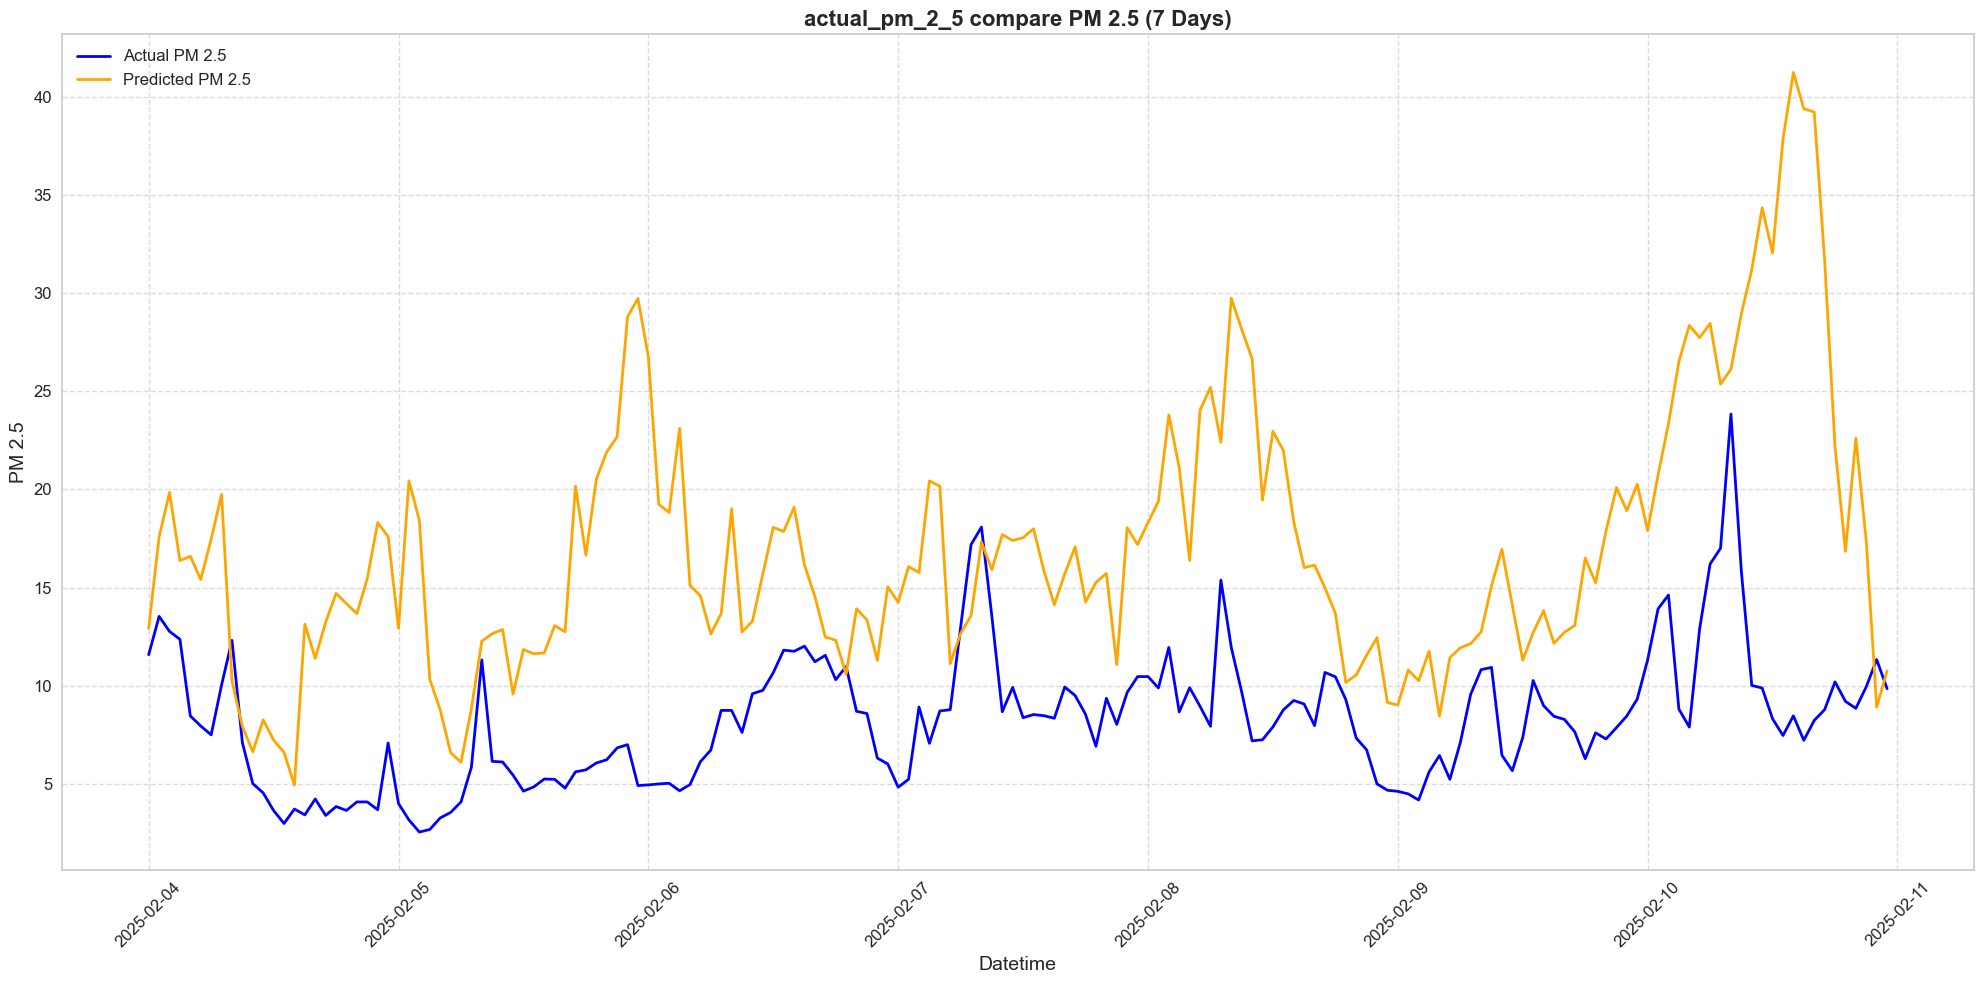

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# โหลดไฟล์เก่า (สำหรับการเปรียบเทียบค่าจริง)
file_path_old = r"D:\Term_Project\pm_2.5\export-jsps013-1h.csv"
df_old = pd.read_csv(file_path_old)

# ฟังก์ชันสำหรับจัดการ outlier และ NaN ด้วย Hybrid Imputation
def hybrid_imputation(series):
    # คำนวณ IQR
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    # กำหนดขอบเขตของ outlier
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # คำนวณค่ากลางจากข้อมูลที่ไม่ใช่ outlier
    non_outlier_values = series[(series >= lower_bound) & (series <= upper_bound)]
    median_value = non_outlier_values.median() if not non_outlier_values.empty else series.median()

    # แทนที่ outlier ด้วยค่าเฉลี่ยของค่าข้างเคียงแทนค่ามัธยฐานคงที่
    series = series.mask((series < lower_bound) | (series > upper_bound), np.nan)
    series = series.interpolate(method="linear")  # เติมค่าที่ขาดหายด้วย Interpolation
    series = series.fillna(median_value)  # ถ้ายังมี NaN อยู่ให้เติมด้วยค่ากลาง

    return series


# เช็คและแปลง datetime ของไฟล์เก่า
df_old["datetime"] = pd.to_datetime(df_old["datetime"], dayfirst=True, errors="coerce")
df_old["pm_2_5"] = pd.to_numeric(df_old["pm_2_5"], errors="coerce")

# ใช้ Hybrid Imputation สำหรับคอลัมน์ 'pm_2_5' ในไฟล์เก่า
df_old["pm_2_5"] = hybrid_imputation(df_old["pm_2_5"])

# ดึงค่าจริงจากไฟล์เก่า (168 ชั่วโมงสุดท้าย)
actual_values_old = df_old['pm_2_5'].iloc[-168:].reset_index(drop=True)



# ---- เปรียบเทียบและพล็อตกราฟ ----
# เพิ่มคอลัมน์ 'actual_pm_2_5' ใน predictions DataFrame
predictions['actual_pm_2_5'] = actual_values_old

# พล็อตกราฟเปรียบเทียบ
plt.figure(figsize=(20, 10))  # ตั้งค่าขนาดกราฟ

# พล็อตเส้นกราฟ
plt.plot(predictions['datetime'], predictions['actual_pm_2_5'], label='Actual PM 2.5 ', marker='x', markersize=8, linewidth=2, color='blue') #(จากไฟล์เก่า)
plt.plot(predictions['datetime'], predictions['prediction_label'], label='Predicted PM 2.5 ', marker='x', markersize=8, linewidth=2, color='orange') #(ค่าทำนาย)

# เพิ่มเส้นกริด
plt.grid(True, linestyle='--', alpha=0.7)

# ปรับแต่งแกน X และ Y
plt.xlabel('Datetime', fontsize=14)
plt.ylabel('PM 2.5', fontsize=14)
plt.xticks(rotation=45, fontsize=12)  # ปรับ rotation และขนาด font ของแกน X
plt.yticks(fontsize=12)  # ปรับขนาด font ของแกน Y

# เพิ่ม title และ legend
plt.title('actual_pm_2_5 compare PM 2.5 (7 Days)', fontsize=16, fontweight='bold')
plt.legend(fontsize=12, loc='upper left')

# ปรับ layout เพื่อไม่ให้ข้อมูลถูกตัด
plt.tight_layout()

# แสดงกราฟ
plt.show()

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

# แบ่งข้อมูลเป็นชุดฝึกและชุดทดสอบ
X = df_cleaned.drop(columns=["pm_2_5", "datetime"])  # ฟีเจอร์
y = df_cleaned["pm_2_5"]  # เป้าหมาย (target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# สร้างและฝึกโมเดล
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# ทำนายค่าบนชุดฝึกและชุดทดสอบ
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# ประเมินประสิทธิภาพด้วย MSE, R², และ MAPE
test_mse = mean_squared_error(y_test, y_test_pred)

test_r2 = r2_score(y_test, y_test_pred)

test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

# แสดงผลลัพธ์
print(f"Test MSE: {test_mse}")
print(f"Test R²: {test_r2}")
print(f"Test MAPE: {test_mape}")


Test MSE: 18.793174610759053
Test R²: 0.812008277514635
Test MAPE: 0.304473345499157


Humidity next 7 days

In [17]:
import pandas as pd
import numpy as np
from pycaret.regression import *
from datetime import timedelta

# โหลดไฟล์ CSV
file_path = "D:/Term_Project/pm_2.5/export-jsps013-1h.csv"
df = pd.read_csv(file_path)

# แปลง datetime เป็นชนิด datetime
df["datetime"] = pd.to_datetime(df["datetime"], dayfirst=True, errors="coerce")

# แปลง 'humidity' เป็นตัวเลข
df["humidity"] = pd.to_numeric(df["humidity"], errors="coerce")

# ลบค่าที่หายไป
df.dropna(inplace=True)

# ฟังก์ชัน Hybrid Imputation
def hybrid_imputation(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    median_value = series.median()
    
    series = series.mask((series < lower_bound) | (series > upper_bound), np.nan)
    series = series.interpolate(method="linear")  # Interpolate ค่า missing
    series = series.fillna(median_value)  # เติมค่าที่หายไปด้วยค่ามัธยฐาน
    return series

# ใช้ Hybrid Imputation
for col in ["humidity", "temperature"]:
    df[col] = hybrid_imputation(df[col])

# สร้าง Feature Lag
df.sort_values("datetime", inplace=True)
for lag in [1, 3, 6, 24]:
    df[f"humidity_lag_{lag}"] = df["humidity"].shift(lag)
    df[f"temperature_lag_{lag}"] = df["temperature"].shift(lag)

# สร้างค่าเฉลี่ยย้อนหลัง (Rolling Mean)
df["humidity_rolling_6"] = df["humidity"].rolling(window=6).mean()
df["humidity_rolling_24"] = df["humidity"].rolling(window=24).mean()

# ลบแถวที่มีค่า NaN หลังจากสร้าง Lag
df.dropna(inplace=True)

# เพิ่ม Feature เชิงเวลา
df["hour"] = df["datetime"].dt.hour
df["dayofweek"] = df["datetime"].dt.dayofweek

# ตั้งค่า PyCaret
exp = setup(
    df,
    target="humidity",
    train_size=0.8,
    session_id=42,
    normalize=True,
    remove_multicollinearity=True,
    feature_selection=True,
    transformation=True
)

# สร้างโมเดล Random Forest
rf_model = create_model("rf")

# ---- พยากรณ์ล่วงหน้า 7 วัน (168 ชั่วโมง) ----
last_date = df["datetime"].max()
future_dates = [last_date + timedelta(hours=i) for i in range(1, 169)]

# สร้าง DataFrame ที่มีคอลัมน์ที่จำเป็นทั้งหมด
# ดึงรายชื่อคอลัมน์จากข้อมูลที่ใช้ train ยกเว้น target
train_columns = list(df.drop('humidity', axis=1).columns)

# Initialize future_data with datetime
future_data = pd.DataFrame({"datetime": future_dates})
future_data["hour"] = future_data["datetime"].dt.hour
future_data["dayofweek"] = future_data["datetime"].dt.dayofweek

# เพิ่มคอลัมน์ที่จำเป็นอื่นๆ
for col in train_columns:
    if col not in future_data.columns:
        # ถ้าเป็นคอลัมน์ datetime ไม่ต้องทำอะไร
        if col == "datetime":
            continue
        # คัดลอกค่าล่าสุดจาก df
        future_data[col] = df[col].iloc[-1]

# ทำนายค่า Humidity
predictions = predict_model(rf_model, data=future_data)

# แสดงผลลัพธ์
time_series_predictions = predictions[["datetime", "prediction_label"]]
print(time_series_predictions.head(168))

# บันทึกผลลัพธ์เป็นไฟล์ CSV
time_series_predictions.to_csv("D:/Term_Project/pm_2.5/predicted_humidity.csv", index=False)
print("บันทึกผลลัพธ์การพยากรณ์สำเร็จ!")

,Description,Value
0,Session id,42
1,Target,humidity
2,Target type,Regression
3,Original data shape,"(22930, 16)"
4,Transformed data shape,"(22930, 4)"
5,Transformed train set shape,"(18344, 4)"
6,Transformed test set shape,"(4586, 4)"
7,Numeric features,14
8,Date features,1
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.1491,9.0595,3.0099,0.8838,0.0633,0.0455
1,2.1661,9.0091,3.0015,0.8807,0.0627,0.0455
2,2.1209,8.2861,2.8786,0.8935,0.0591,0.0445
3,2.1360,9.0241,3.0040,0.8821,0.0627,0.0448
4,2.1393,8.5094,2.9171,0.8834,0.0606,0.0447
5,2.0905,7.9074,2.8120,0.8918,0.0591,0.0439
6,2.2001,9.3003,3.0496,0.8787,0.0630,0.0460
7,2.1133,8.5501,2.9241,0.8844,0.0613,0.0448
8,2.0521,7.6967,2.7743,0.8895,0.0585,0.0436


               datetime  prediction_label
0   2025-02-11 00:00:00         43.688735
1   2025-02-11 01:00:00         45.159805
2   2025-02-11 02:00:00         45.267634
3   2025-02-11 03:00:00         45.174158
4   2025-02-11 04:00:00         45.032652
..                  ...               ...
163 2025-02-17 19:00:00         43.604733
164 2025-02-17 20:00:00         43.597438
165 2025-02-17 21:00:00         43.632538
166 2025-02-17 22:00:00         43.650863
167 2025-02-17 23:00:00         43.128016

[168 rows x 2 columns]
บันทึกผลลัพธ์การพยากรณ์สำเร็จ!


Temperature next 7 Days

In [18]:
import pandas as pd
from pycaret.regression import *
from datetime import timedelta
import numpy as np

# โหลดไฟล์ CSV
file_path = "D:\Term_Project\pm_2.5\export-jsps013-1h.csv"
df = pd.read_csv(file_path)

# แปลง datetime เป็นชนิด datetime
df["datetime"] = pd.to_datetime(df["datetime"], dayfirst=True, errors="coerce")

# แปลง 'temperature' เป็นตัวเลข
df["temperature"] = pd.to_numeric(df["temperature"], errors="coerce")

# ลบคอลัมน์ 'pm_2_5' และ 'humidity' (หากยังอยู่ใน DataFrame)
for col in ["pm_2_5", "humidity"]:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

# สร้างสำเนา DataFrame เพื่อใช้ทำความสะอาดข้อมูล
df_cleaned = df.copy()

# ฟังก์ชัน Hybrid Imputation
def hybrid_imputation(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    non_outlier_values = series[(series >= lower_bound) & (series <= upper_bound)]
    median_value = non_outlier_values.median() if not non_outlier_values.empty else series.median()

    series = series.mask((series < lower_bound) | (series > upper_bound), np.nan)
    series = series.interpolate(method="linear")  
    series = series.fillna(median_value)  

    return series

# ใช้ Hybrid Imputation สำหรับ 'temperature'
df_cleaned["temperature"] = hybrid_imputation(df_cleaned["temperature"])

# สร้างฟีเจอร์ย้อนหลังของ temperature
for lag in [1, 3, 6, 24]:
    df_cleaned[f"temperature_lag_{lag}"] = df_cleaned["temperature"].shift(lag)

# ลบแถวที่มีค่า NaN หลังจากสร้าง Lag
df_cleaned.dropna(inplace=True)

# ตั้งค่า PyCaret และแบ่ง train 80% test 20%
exp = setup(df_cleaned, target="temperature", train_size=0.8, session_id=42, normalize=True, feature_selection=True)

# สร้างโมเดล Random Forest Regressor
model = create_model("rf")

# ---- สร้างข้อมูลสำหรับพยากรณ์ล่วงหน้า 7 วัน (168 ชั่วโมง) ----
last_date = df_cleaned["datetime"].max()
future_dates = [last_date + timedelta(hours=i) for i in range(1, 169)]

# ใช้ค่าล่าสุดของ temperature
latest_temperature = df_cleaned["temperature"].iloc[-1]

future_data = pd.DataFrame({
    "datetime": future_dates,
    "temperature_lag_1": [latest_temperature] * len(future_dates),
    "temperature_lag_3": [latest_temperature] * len(future_dates),
    "temperature_lag_6": [latest_temperature] * len(future_dates),
    "temperature_lag_24": [latest_temperature] * len(future_dates)
})

# เพิ่มฟีเจอร์เชิงเวลา
future_data["hour"] = future_data["datetime"].dt.hour
future_data["dayofweek"] = future_data["datetime"].dt.dayofweek

# Recursive forecasting
for i in range(len(future_data)):
    pred = predict_model(model, data=future_data.iloc[i:i+1])
    predicted_value = pred.iloc[0]["prediction_label"]
    if i + 1 < len(future_data):
        future_data.at[i + 1, "temperature_lag_1"] = predicted_value
    if i + 3 < len(future_data):
        future_data.at[i + 3, "temperature_lag_3"] = predicted_value
    if i + 6 < len(future_data):
        future_data.at[i + 6, "temperature_lag_6"] = predicted_value
    if i + 24 < len(future_data):
        future_data.at[i + 24, "temperature_lag_24"] = predicted_value

# ทำนายค่า Temperature
predictions = predict_model(model, data=future_data)

# หาชื่อคอลัมน์การทำนายที่ถูกต้อง
prediction_column = [col for col in predictions.columns if "predict" in col.lower()]
if prediction_column:
    prediction_column = prediction_column[0]
    print(predictions[["datetime", prediction_column]])
else:
    print("ไม่พบคอลัมน์การทำนาย ลองแสดงผลทั้งหมด:")
    print(predictions.head())

# บันทึกผลลัพธ์เป็นไฟล์ CSV
predictions.to_csv("D:/Term_Project/pm_2.5/predicted_temperature.csv", index=False)
print("บันทึกผลลัพธ์การพยากรณ์สำเร็จ!")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1070
[LightGBM] [Info] Number of data points in the train set: 18344, number of used features: 7
[LightGBM] [Info] Start training from score 34.463169


,Description,Value
0,Session id,42
1,Target,temperature
2,Target type,Regression
3,Original data shape,"(22930, 6)"
4,Transformed data shape,"(22930, 2)"
5,Transformed train set shape,"(18344, 2)"
6,Transformed test set shape,"(4586, 2)"
7,Numeric features,4
8,Date features,1
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.0299,1.9676,1.4027,0.7905,0.0392,0.0298
1,1.0257,1.9016,1.3790,0.7833,0.0387,0.0298
2,1.0186,1.8749,1.3693,0.7958,0.0386,0.0297
3,1.0064,1.8364,1.3551,0.7977,0.0379,0.0291
4,1.0251,1.8561,1.3624,0.7862,0.0383,0.0298
5,1.0100,1.8140,1.3468,0.7984,0.0377,0.0292
6,1.0317,1.8831,1.3723,0.7908,0.0385,0.0300
7,1.0200,1.8340,1.3542,0.7869,0.0379,0.0296
8,1.0155,1.7787,1.3337,0.7875,0.0372,0.0294


               datetime  prediction_label
0   2025-02-11 00:00:00         33.955350
1   2025-02-11 01:00:00         34.784517
2   2025-02-11 02:00:00         34.018531
3   2025-02-11 03:00:00         33.487160
4   2025-02-11 04:00:00         34.364235
..                  ...               ...
163 2025-02-17 19:00:00         33.876294
164 2025-02-17 20:00:00         33.771180
165 2025-02-17 21:00:00         33.657665
166 2025-02-17 22:00:00         33.798971
167 2025-02-17 23:00:00         34.559749

[168 rows x 2 columns]
บันทึกผลลัพธ์การพยากรณ์สำเร็จ!


TRAIN (EXTRA TREE)

In [11]:
import pandas as pd
from pycaret.regression import *
from datetime import timedelta
import numpy as np

# โหลดไฟล์ CSV
file_path = "D:\Term_Project\pm_2.5\cleaned_data (2)-7days.csv"
df = pd.read_csv(file_path)

# แปลง datetime เป็นชนิด datetime
df["datetime"] = pd.to_datetime(df["datetime"], dayfirst=True, errors="coerce")

# แปลง 'pm_2_5' เป็นตัวเลข
df["pm_2_5"] = pd.to_numeric(df["pm_2_5"], errors="coerce")

# สร้างสำเนา DataFrame เพื่อใช้ทำความสะอาดข้อมูล
df_cleaned = df.copy()

# ฟังก์ชันสำหรับจัดการ outlier และ NaN ด้วย Hybrid Imputation
def hybrid_imputation(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    median_value = series.median()
    series = series.where((series >= lower_bound) & (series <= upper_bound), median_value)
    series = series.fillna(median_value)
    return series

# ใช้ Hybrid Imputation สำหรับคอลัมน์ 'pm_2_5'
df_cleaned["pm_2_5"] = hybrid_imputation(df_cleaned["pm_2_5"])

# สร้างฟีเจอร์ย้อนหลัง
for lag in [1, 3, 6, 24]:
    df_cleaned[f"pm_2_5_lag_{lag}"] = df_cleaned["pm_2_5"].shift(lag)

# ตั้งค่า PyCaret และแบ่ง train 80% test 20%
exp = setup(df_cleaned, target="pm_2_5", train_size=0.8, session_id=42, normalize=True, feature_selection=True)

# ปรับแต่งโมเดล Extra Trees Regressor
model = create_model("et")

# ---- สร้างข้อมูลสำหรับพยากรณ์ล่วงหน้า 7 วัน (168 ชั่วโมง) ----
last_date = df_cleaned["datetime"].max()
future_dates = [last_date + timedelta(hours=i) for i in range(1, 169)]

latest_humidity = df_cleaned["humidity"].iloc[-24:].mean()
latest_temperature = df_cleaned["temperature"].iloc[-24:].mean()
latest_pm25 = df_cleaned["pm_2_5"].iloc[-1]

future_data = pd.DataFrame({
    "datetime": future_dates,
    "humidity": [latest_humidity] * len(future_dates),
    "temperature": [latest_temperature] * len(future_dates),
    "pm_2_5_lag_1": [latest_pm25] * len(future_dates),
    "pm_2_5_lag_3": [latest_pm25] * len(future_dates),
    "pm_2_5_lag_6": [latest_pm25] * len(future_dates),
    "pm_2_5_lag_24": [latest_pm25] * len(future_dates)
})

# เพิ่มฟีเจอร์เชิงเวลา
future_data["hour"] = future_data["datetime"].dt.hour
future_data["dayofweek"] = future_data["datetime"].dt.dayofweek

# Recursive forecasting
for i in range(len(future_data)):
    pred = predict_model(model, data=future_data.iloc[i:i+1])
    predicted_value = pred.iloc[0]["prediction_label"]
    if i + 1 < len(future_data):
        future_data.at[i + 1, "pm_2_5_lag_1"] = predicted_value
    if i + 3 < len(future_data):
        future_data.at[i + 3, "pm_2_5_lag_3"] = predicted_value
    if i + 6 < len(future_data):
        future_data.at[i + 6, "pm_2_5_lag_6"] = predicted_value
    if i + 24 < len(future_data):
        future_data.at[i + 24, "pm_2_5_lag_24"] = predicted_value

# ทำนายค่า PM 2.5
predictions = predict_model(model, data=future_data)

# หาชื่อคอลัมน์การทำนายที่ถูกต้อง
prediction_column = [col for col in predictions.columns if "predict" in col.lower()]
if prediction_column:
    prediction_column = prediction_column[0]
    print(predictions[["datetime", prediction_column]])
else:
    print("ไม่พบคอลัมน์การทำนาย ลองแสดงผลทั้งหมด:")
    print(predictions.head())


,Description,Value
0,Session id,42
1,Target,pm_2_5
2,Target type,Regression
3,Original data shape,"(34465, 8)"
4,Transformed data shape,"(34465, 2)"
5,Transformed train set shape,"(27572, 2)"
6,Transformed test set shape,"(6893, 2)"
7,Numeric features,6
8,Date features,1
9,Rows with missing values,0.1%


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.0830,23.1413,4.8105,0.6735,0.3411,0.3266
1,3.1334,24.7057,4.9705,0.6789,0.3398,0.3249
2,3.0178,22.5155,4.7451,0.6885,0.3327,0.3159
3,3.1188,23.9389,4.8927,0.6546,0.3360,0.3736
4,3.0401,22.2552,4.7175,0.6997,0.3343,0.3209
5,3.1081,22.3312,4.7256,0.6905,0.3302,0.3151
6,3.1893,23.5600,4.8539,0.6744,0.3405,0.3332
7,3.0579,22.5793,4.7518,0.6783,0.3430,0.3375
8,3.0564,22.4708,4.7403,0.6940,0.3323,0.3656


               datetime  prediction_label
0   2025-01-28 00:00:00         17.409315
1   2025-01-28 01:00:00         15.058259
2   2025-01-28 02:00:00         14.505208
3   2025-01-28 03:00:00         20.632487
4   2025-01-28 04:00:00         24.464285
..                  ...               ...
163 2025-02-03 19:00:00          9.778274
164 2025-02-03 20:00:00          9.070138
165 2025-02-03 21:00:00          9.140615
166 2025-02-03 22:00:00          7.088001
167 2025-02-03 23:00:00          8.207350

[168 rows x 2 columns]
